# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
26735,36583,81535,NaN,07-04-2020,Govt of Guinea announces it will cover water&a...,Positive
19567,27623,72575,NaN,26-03-2020,@Direct773 \r\r\n@Direct7E\r\r\n#Pennsylvania ...,Extremely Negative
18187,25928,70880,NaN,25-03-2020,@Tejasvi_Surya Precisely. And what is the hurr...,Extremely Negative
23917,33034,77986,"Bucure?ti, RomÃÂ¢nia",05-04-2020,Online grocery shopping is recommended these d...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
df.iloc[:,5].value_counts()

,count
Sentiment,
Positive,11422
Negative,9917
Extremely Positive,6624
Extremely Negative,5481


In [ ]:
def OHE(data: str):
  if 'Positive' in data:
    return 1
  elif 'Negative' in data:
    return 0

df['Sentiment'] = df['Sentiment'].apply(OHE)

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [ ]:
df['Sentiment'].value_counts()  # как мы видим, сумма дает 33444, то есть функция работает правильно

,count
Sentiment,
1,18046
0,15398


**Ответ:** Классы не сбаланисированы, потому что разница между позитивными и негативными твитами около 3000.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
df.isna().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


Как можно заметить в столбце *Location* есть пропуски.

In [ ]:
df["Location"].fillna('Unknown', inplace=True)

In [ ]:
df.isna().any() #Везде false значит нет пропусков

,0
UserName,False
ScreenName,False
Location,False
TweetAt,False
OriginalTweet,False
Sentiment,False


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
tweet_dict = {}
tweet_str = ''
for twit in train['OriginalTweet']:
  tweet_str = twit.lower().split()
  for row in tweet_str:
    if row in tweet_dict.keys():
      tweet_dict[row] +=1
    else:
      tweet_dict[row] = 1

Какой размер словаря получился?

In [ ]:
len(tweet_dict)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
sorted_tweet_dict = sorted(tweet_dict, key=tweet_dict.get, reverse=True)

for key in sorted_tweet_dict[:10]:
  print(key, tweet_dict[key])

the 26815
to 23373
and 14684
of 13012
a 11737
in 11198
for 8566
#coronavirus 8223
is 7383
are 7050


**Ответ:** Эти токены в топе, потому что в основном тут слова паразиты и стоп слова, которые мы в повседневной жизни очень часто используем. Также тут #coronavirus, так как тема про корону;)


Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words("english"))

for word in stop_words:
  if word in tweet_dict.keys():
    del tweet_dict[word]

In [ ]:
sorted_tweet_dict_wt_sw = sorted(tweet_dict, key=tweet_dict.get, reverse=True) #wt_sw это without stopwords

for key in sorted_tweet_dict_wt_sw[:10]:
  print(key, tweet_dict[key])

#coronavirus 8223
prices 3891
food 3820
grocery 3469
supermarket 3288
people 3175
covid-19 3173
store 3155
#covid19 2471
&amp; 2314


**Ответ:**  Тут слова уже более осмысленные. Тут можно заметить, что в твиттере очень бурно обсуждали цены на продукцию, дифицит товаров и многое другое, что произошло во время короновируса. Ну и сам короновирус и 19 часто встречаются в твиттах.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
for key in sorted_tweet_dict_wt_sw[len(sorted_tweet_dict_wt_sw):len(sorted_tweet_dict_wt_sw)-21:-1]:
  print(key, tweet_dict[key])

https://t.co/7j2y3rsld9 1
@680news 1
@torontopearson 1
nothing... 1
flew 1
wage! 1
renewing 1
playersãâ 1
subsidise 1
non-playing 1
premiership 1
https://t.co/iaek4fwsgz 1
@srinivasiyc 1
https://t.co/zjcl195vqs 1
#southkerry 1
#skelligcoast2kms 1
@skelligsix18 1
closer!) 1
coast! 1
skellig 1


**Ответ:** Эти токены непопулярные, так как тут присутствуют символы со словами и ссылки на другие твиты. С этими токенами скорее всего нужно дополнительно поработать, так как символы могут иметь важную роль при предсказании окраса твита (как способ выражения эмоций).



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()

tweet_dict_tt = {}
tweet_str_tt = ''
for twit in train['OriginalTweet']:
  tweet_str_tt = tweet_tokenizer.tokenize(twit)
  for row in tweet_str_tt:
    if row.lower() in tweet_dict_tt.keys():
      tweet_dict_tt[row.lower()] +=1
    else:
      tweet_dict_tt[row.lower()] = 1

In [ ]:
sorted_tweet_dict_tt = sorted(tweet_dict_tt, key=tweet_dict_tt.get, reverse=True)

for key in sorted_tweet_dict_tt[:10]:
  print(key, tweet_dict_tt[key])

the 26993
. 24118
to 23478
, 17571
and 14825
of 13044
a 11891
in 11348
? 9524
#coronavirus 8808


**Ответ:** Как можно заметить, теперь самые популярные "слова" это символы. Так как *TweetTokenizer* разделяет символы от слов, в отличии от *split*, то топ сильно поменялся.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

for word in stop_words: #Удаляем стоп слова и слова паразиты
  if word.lower() in tweet_dict_tt.keys():
    del tweet_dict_tt[word]

for pun in list(punctuation): #Удаляем пунктуацию
  if pun in tweet_dict_tt.keys():
    del tweet_dict_tt[pun]

In [ ]:
sorted_tweet_dict_tt_clear = sorted(tweet_dict_tt, key=tweet_dict_tt.get, reverse=True)

for key in sorted_tweet_dict_tt_clear[:10]:
  print(key, tweet_dict_tt[key])

#coronavirus 8808
â 7415
 7311
19 7167
covid 6253
prices 4601
 4372
food 4367
store 3877
supermarket 3805


**Ответ:** Теперь в топ какие то странные символы, которые не имеют смысла, и которые надо удалить.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
tweet_dict_tt_1 = tweet_dict_tt.copy()

for key in tweet_dict_tt_1.keys():
  if (len(key.lower())==1 and ord(key) >= 128):
    del tweet_dict_tt[key]

In [ ]:
sorted_tweet_dict_tt_clear2 = sorted(tweet_dict_tt, key=tweet_dict_tt.get, reverse=True)

for word in sorted_tweet_dict_tt_clear2[:10]:
  print(word, tweet_dict_tt[word])

#coronavirus 8808
19 7167
covid 6253
prices 4601
food 4367
store 3877
supermarket 3805
grocery 3523
people 3463
#covid19 2589


**Ответ:** Теперь топы стали чище и лучше, теперь четко можно понять, что главной темой в твиттере была изменение цен на продукты в супермаркете.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
for_heshtag = {} # Пустой словарь
target = "#"
for word in tweet_dict_tt.keys():
  if any(sym in word for sym in target):
    dict_1 = {word:tweet_dict_tt[word]}
    for_heshtag.update(dict_1) #Закидываем в пустой словарь

sorted_dict_ht = sorted(for_heshtag, key=for_heshtag.get, reverse=True) #Сортируем по значению

for key in sorted_dict_ht[:10]: #Выводим первые 10
  print(key, for_heshtag[key])

#coronavirus 8808
#covid19 2589
#covid_19 1734
#covid2019 946
#toiletpaper 744
#covid 641
#socialdistancing 465
#coronacrisis 448
#pandemic 257
#coronaviruspandemic 249


**Ответ:** Все хэштегы про ковид 19, социальную дистанцию и туалетную бумагу;)

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
for_link = {} # Пустой словарь
target_1 = ["https://t.co"]
for word in tweet_dict_tt.keys():
  if any(sym in word for sym in target_1):
    dict_2 = {word:tweet_dict_tt[word]}
    for_link.update(dict_2) #Закидываем в пустой словарь

sorted_dict_link = sorted(for_link, key=for_link.get, reverse=True) #Сортируем по значению

for key in sorted_dict_link[:10]: #Выводим первые 10
  print(key, tweet_dict_tt[key])

https://t.co/oxa7swtond 5
https://t.co/gp3eusapl8 4
https://t.co/deftrui1pfãâ 3
https://t.co/wrlhyzizaa 3
https://t.co/kuwipf1kqw 3
https://t.co/zjnrx6dkkn 3
https://t.co/3gbbdpdjat 3
https://t.co/e2znxajpre 3
https://t.co/catkegayoy 3
https://t.co/g63rp042ho 3


**Ответ:** Тут как можно заметить некоторые твиты повторяются, может быть они имеют важную ценность и могут помочь узнать эмоциональный окрас твита.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  text_1 = text.lower()
  list_tokens = tweet_tokenizer.tokenize(text_1)
  tokens = list_tokens.copy()
  for word in list_tokens:
     if word in list(stop_words) or word in list(punctuation) or (len(word) == 1 and ord(word) >= 128) or word[0:12] == 'https://t.co':
      tokens.remove(word)

  return tokens


In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(tokenizer = custom_tokenizer)

vectorized_cv = cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

45308


**Ответ:** Теперь словарь стал почти в 2 раза меньше

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
text = [train.iloc[9023]['OriginalTweet']]
vectorized_cv = cv.fit_transform(text)

tokens_name = cv.get_feature_names_out(text)

vector_array = vectorized_cv.toarray()

important_token = tokens_name[np.argmax(vector_array)]
unimportant_token = tokens_name[np.argmin(vector_array)]
important_token, unimportant_token

('#coronavirusoutbreak', '#coronavirusoutbreak')

In [ ]:
pd.DataFrame(data=vector_array, columns=tokens_name)

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Ответ:** По датафрейму можно понять, что у всех слов весь равен 1, поэтому нельзя виделить наиболее или наименее важный токен.



Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)

full_text = tfidf_vec.fit_transform(train['OriginalTweet'])

vec = pd.DataFrame(data=full_text.toarray(), columns=tfidf_vec.get_feature_names_out()).iloc[[9023]]
vec = vec.drop(columns=vec.columns[vec.iloc[0] == 0])
vec

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
9023,0.225843,0.168252,0.310426,0.386764,0.324474,0.113289,0.320473,0.301211,0.254273,0.163067,0.147595,0.255006,0.354346,0.244065


In [ ]:
max_w_name = vec.idxmax(axis=1)
min_w_name = vec.idxmin(axis=1)
max_w = vec.max(axis=1)
min_w =vec.min(axis=1)
print(f"Максимальный вес имеет {max_w_name} cо значением {max_w}")
print(f"Минимальный вес имеет {min_w_name} cо значением {min_w}")

Максимальный вес имеет 9023    brainless
dtype: object cо значением 9023    0.386764
dtype: float64
Минимальный вес имеет 9023    food
dtype: object cо значением 9023    0.113289
dtype: float64


**Ответ:** Данный метод векторизации помог нам выделить самый важный токен - brainless, и наименее значимый токен - food.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'excellent' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21031,29445,74397,"Falls Church, VA",01-04-2020,I have to shout @Publix grocery store ? you gu...,1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
29486,39993,84945,"New York, USA",09-04-2020,Finances are a real issue for many Learn about...,1
14334,21202,66154,"Ohio, USA",23-03-2020,@drsmadden A5: I think brands are doing an exc...,1
8740,14419,59371,Nevada,20-03-2020,My betrothed is a type-1 diabetic and manager ...,1
18296,26062,71014,"Somerville, MA",25-03-2020,@UMassBoston @UMB_UR_BEST doctoral students wr...,1
14563,21497,66449,Manchester,23-03-2020,An excellent description from of the six thres...,1
24155,33326,78278,"Langtoun, UK",05-04-2020,Local supermarket has a pre-opening hour exclu...,1
11469,17705,62657,Zurich - Dublin,21-03-2020,we ve put together a list of excellent recipe ...,1
19273,27258,72210,3rd planet in minor solar sys,26-03-2020,Talked to the excellent about about transmissi...,1


In [ ]:
index = 5462
vec_1 = pd.DataFrame(data=full_text.toarray(), columns=tfidf_vec.get_feature_names_out()).iloc[[index]]
vec_1 = vec_1.drop(columns=vec_1.columns[vec_1.iloc[0] == 0])
vec_1

,behavior,consumer,description,excellent,means,phases,result,six,thresholds
5462,0.256677,0.148265,0.45937,0.337931,0.272415,0.410693,0.265492,0.31334,0.418772


In [ ]:
train.iloc[ind]['OriginalTweet']

'Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs'

**Ответ:** Я выбрал слово 'excellent', и как мы видим, он имеет большой вес для описания твита, так как тут написано как хорошо были описаны какие-то фазы поведения человека.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
X_train = train.loc[:, train.columns != 'Sentiment']
y_train = train['Sentiment']

X_test = test.loc[:, test.columns != 'Sentiment']
y_test = test['Sentiment']

train_tweet_cv = cv.fit_transform(X_train['OriginalTweet'])
test_tweet_cv = cv.transform(X_test['OriginalTweet'])

train_tweet_tfidf = tfidf_vec.fit_transform(X_train['OriginalTweet'])
test_tweet_tfidf = tfidf_vec.transform(X_test['OriginalTweet'])

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
for_cv_fit = logreg.fit(train_tweet_cv, y_train)

print(f"Accuracy для cv на train {accuracy_score(for_cv_fit.predict(train_tweet_cv),y_train)}")
print(f"Accuracy для cv на test {accuracy_score(for_cv_fit.predict(test_tweet_cv),y_test)}")

Accuracy для cv на train 0.9844510892780863
Accuracy для cv на test 0.8674506677297189


In [ ]:
for_tfidf_fit = logreg.fit(train_tweet_tfidf, y_train)
print(f"Accuracy для tfidf на train {accuracy_score(for_tfidf_fit.predict(train_tweet_tfidf),y_train)}")
print(f"Accuracy для tfidf на test {accuracy_score(for_tfidf_fit.predict(test_tweet_tfidf),y_test)}")

**Ответ:** На countvectorizer-e качество хуже, чем y tfidf. Также можно заметить переобучение у CV.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def custom_stem_tokenizer(text):
  text_1 = text.lower()
  list_tokens = tweet_tokenizer.tokenize(text_1)
  tokens = list_tokens.copy()
  for word in list_tokens:
     if word in list(stop_words) or word in list(punctuation) or (len(word) == 1 and ord(word) >= 128) or word[0:12] == 'https://t.co':
      tokens.remove(word)

  tokens_new = []
  for word in tokens:
    token_stem = stemmer.stem(word)
    tokens_new.append(token_stem)

  return tokens_new

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)
tfidf = TfidfVectorizer(tokenizer = custom_stem_tokenizer)

train_tweet_cv = cv.fit_transform(X_train['OriginalTweet'])
train_tweet_tfidf = tfidf.fit_transform(X_train['OriginalTweet'])

print(len(cv.vocabulary_))

36652


**Ответ** Словарь уменьшился около на 12к слов, что поможет сократить время при обучении модели и сохранить самые важные токены.


Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
test_tweet_cv = cv.transform(X_test['OriginalTweet'])

logreg.fit(train_tweet_cv, y_train)
print(f"Accuracy для cv на train {accuracy_score(logreg.predict(train_tweet_cv),y_train)}")
print(f"Accuracy для cv на test {accuracy_score(logreg.predict(test_tweet_cv),y_test)}")

Accuracy для cv на train 0.9717642033319095
Accuracy для cv на test 0.8674506677297189


In [ ]:
test_tweet_tfidf = tfidf.transform(X_test['OriginalTweet'])

logreg.fit(train_tweet_tfidf, y_train)
print(f"Accuracy для tfidf на train {accuracy_score(logreg.predict(train_tweet_tfidf),y_train)}")
print(f"Accuracy для tfidf на test {accuracy_score(logreg.predict(test_tweet_tfidf),y_test)}")

Accuracy для tfidf на train 0.9158906450234943
Accuracy для tfidf на test 0.8560892963922663


**Ответ:** В целом, изменение токенайзера нам ничего не дало, изменение качетсв моделей почти несущественное.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df_max = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df_max.vocabulary_))

36651


In [ ]:
# Обучу логрег тут для df_max

train_tweet_cv_df_max = cv_df_max.fit_transform(X_train['OriginalTweet'])
test_tweet_cv_df_max = cv_df_max.transform(X_test['OriginalTweet'])

logreg.fit(train_tweet_cv_df_max, y_train)

print(f"Accuracy для cv на train {accuracy_score(logreg.predict(train_tweet_cv_df_max),y_train)}")
print(f"Accuracy для cv на test {accuracy_score(logreg.predict(test_tweet_cv_df_max),y_test)}")

Accuracy для cv на train 0.9716360529688167
Accuracy для cv на test 0.8681482957942994


**Ответ:** Ну мы убрали одно слово (скорее всего #coronavirus) из-за этого качество модели почти не изменилось по сравнению с предыдущим обучением. Параметр такой большой, так как мы выкинули всего лишь одно слово, и это самое популярное слово.


Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df_min = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df_min.vocabulary_))

3700


In [ ]:
# Обучу логрег тут тоже для df_min

train_tweet_cv_df_min = cv_df_min.fit_transform(X_train['OriginalTweet'])
test_tweet_cv_df_min = cv_df_min.transform(X_test['OriginalTweet'])

logreg.fit(train_tweet_cv_df_min, y_train)

print(f"Accuracy для cv на train {accuracy_score(logreg.predict(train_tweet_cv_df_min),y_train)}")
print(f"Accuracy для cv на test {accuracy_score(logreg.predict(test_tweet_cv_df_min),y_test)}")

Accuracy для cv на train 0.9284493806065783
Accuracy для cv на test 0.8677496511859677


**Ответ:** На трейне accuracy сильно упал, а на тесте ничего не изменилось. Можно сказать, что модель теперь не переобучен.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False).fit(train_tweet_cv_df_min)
train_tweet_cv_df_min_scaled = scaler.transform(train_tweet_cv_df_min)
test_tweet_cv_df_min_scaled = scaler.transform(test_tweet_cv_df_min)

logreg.fit(train_tweet_cv_df_min_scaled, y_train)

print(f"Accuracy для cv на train {accuracy_score(logreg.predict(train_tweet_cv_df_min_scaled),y_train)}")
print(f"Accuracy для cv на test {accuracy_score(logreg.predict(test_tweet_cv_df_min_scaled),y_test)}")

Accuracy для cv на train 0.9416915847928236
Accuracy для cv на test 0.8447279250548136


Качество модели на тесте увеличилось,как и на трейне по сравнению с предыдущим пунктом.

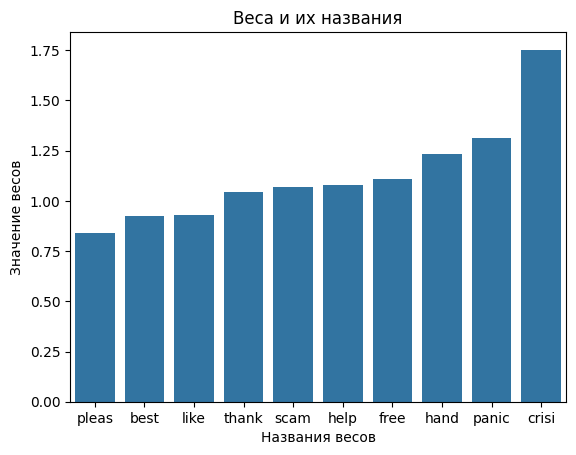

In [ ]:
# Теперь надо будет нарисовать график

coefs = np.abs(logreg.coef_[0])
feature_names = cv_df_min.get_feature_names_out()
top_10_max_w = np.sort(coefs)[-10:]
top_10_max_w_indexes = np.argsort(coefs)[-10:]
top_10_max_w_names = [feature_names[name] for name in top_10_max_w_indexes]

sns.barplot(y=top_10_max_w, x = top_10_max_w_names)
plt.title('Веса и их названия')
plt.xlabel('Названия весов')
plt.ylabel('Значение весов')
plt.show()

**Ответ:** Тут в основном слова, которые хорошо описывают ситуацию или затрагивают важные темы 2020г. Напрмер, кризис, паника, помощь и тд.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
train['ScreenName'].value_counts(ascending=False)

ScreenName
80130    1
80550    1
71612    1
54533    1
53399    1
        ..
65753    1
75228    1
64997    1
77271    1
52056    1
Name: count, Length: 23410, dtype: int64

In [ ]:
train['UserName'].value_counts(ascending=False)

UserName
35178    1
35598    1
26660    1
9581     1
8447     1
        ..
20801    1
30276    1
20045    1
32319    1
7104     1
Name: count, Length: 23410, dtype: int64

**Ответ:** Как мы видим, каждый username и screenname появляется все лишь один раз, поэтому их закодировать и использовать в дальнейшем для построения модели смысла нет.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

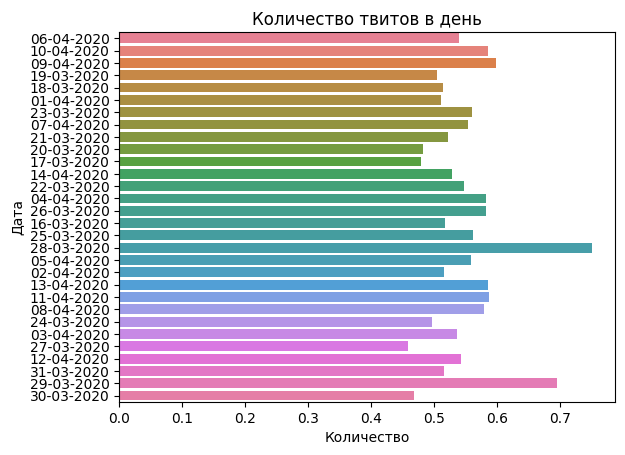

In [ ]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

sns.barplot(y=train['TweetAt'], x=y_train, ci=None, hue=train['TweetAt'])
sns.color_palette("tab10")
plt.title('Количество твитов в день')
plt.xlabel('Количество')
plt.ylabel('Дата')
plt.show()

Как можно видеть в некоторые дни положительные отзыви сильно увеличивались, поэтому можно сказать, что этот столбец важен для нас.

In [ ]:
# Подготовка данных
train_new = pd.get_dummies(train['TweetAt'], drop_first=False, dtype=int)
train_new.reset_index(drop = True , inplace = True)
train_new['index'] = train_new.index
scaled_dataframe = pd.DataFrame(data=train_tweet_cv_df_min_scaled.toarray(), columns=cv_df_min.get_feature_names_out())
scaled_dataframe['index'] = scaled_dataframe.index
train_modify = train_new.merge(scaled_dataframe, on='index')
train_modify = train_modify.loc[:, train_modify.columns != 'index']

test_new = pd.get_dummies(test['TweetAt'], drop_first=False, dtype=int)
test_new.reset_index(drop = True , inplace = True)
test_new['index'] = test_new.index
scaled_dataframe_1 = pd.DataFrame(data=test_tweet_cv_df_min_scaled.toarray(), columns=cv_df_min.get_feature_names_out())
scaled_dataframe_1['index'] = scaled_dataframe_1.index
test_modify = test_new.merge(scaled_dataframe_1, on='index')
test_modify = test_modify.loc[:, test_modify.columns != 'index']
# Сверху я пытался всеми способами объеденить 2 таблицы так, чтобы не появились Nan-ы, хотя размеры таблиц совпадают, поэтому не надо меня жестко судить
# Теперь обучим модель

logreg.fit(train_modify, y_train)
print(f"Accuracy для cv на train {accuracy_score(logreg.predict(train_modify),y_train)}")
print(f"Accuracy для cv на test {accuracy_score(logreg.predict(test_modify),y_test)}")

Accuracy для cv на train 0.9434429730884237
Accuracy для cv на test 0.8427347020131553


**Ответ:** В итоге у меня модель стала хуже на тесте и чуть лучге на трейне, поэтому не имеет смысла использовать время и дни.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
len(train['Location'].unique()) # Количество уникальных значений включая Unknown

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

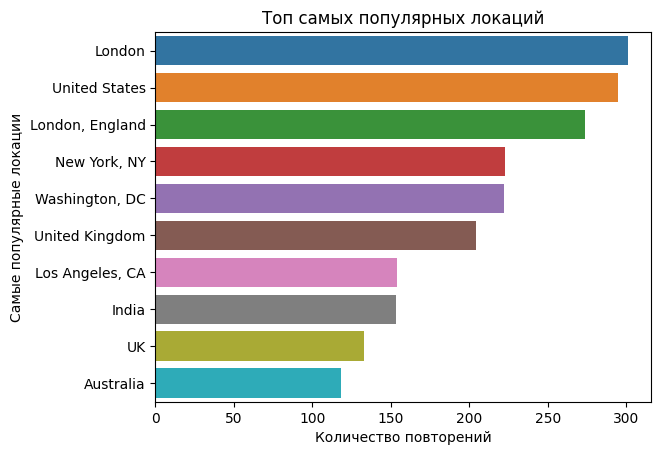

In [ ]:
data_for_location = train[train['Location'] != 'Unknown']

sns.barplot(x=data_for_location['Location'].value_counts(ascending=False).values[:10],
            y=data_for_location['Location'].value_counts(ascending=False).index[:10],
            hue = data_for_location['Location'].value_counts(ascending=False).index[:10])
plt.title('Топ самых популярных локаций')
plt.xlabel('Количество повторений')
plt.ylabel('Самые популярные локации')
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [ ]:
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else x)
test['WiderLocation'] = test['Location'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else x)

len(train['WiderLocation'].unique()) #Включая Unknown

4766

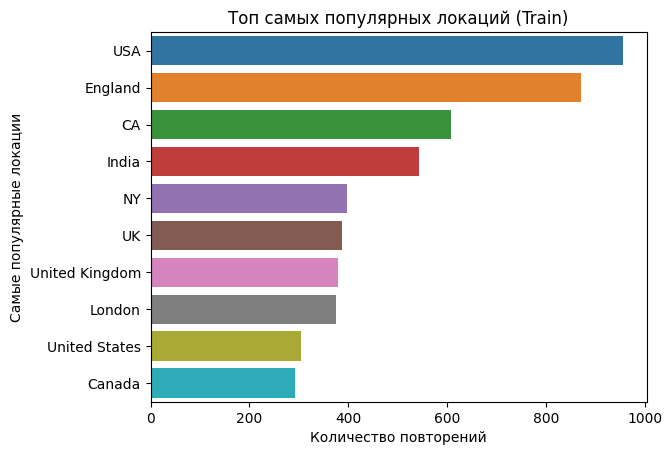

In [ ]:
train_for_widerlocation = train[train['WiderLocation'] != 'Unknown']
sns.barplot(x=train_for_widerlocation['WiderLocation'].value_counts(ascending=False).values[:10],
            y=train_for_widerlocation['WiderLocation'].value_counts(ascending=False).index[:10],
            hue = train_for_widerlocation['WiderLocation'].value_counts(ascending=False).index[:10])
plt.title('Топ самых популярных локаций (Train)')
plt.xlabel('Количество повторений')
plt.ylabel('Самые популярные локации')
plt.show()

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
punc = ['"','#','$',
 '%',
 '&',
 "'",
 '*',
 '+',
 ',',
 '-',
 '.',
 '<',
 '=',
 '>',
 '@',
 '[',
 '\\',
 ']',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [ ]:
# Ну попробуем хотя бы это
# Создам новый токенайзер
from nltk.tokenize import word_tokenize
nltk.download("punkt", quiet=True)
def custom_stem_tokenizer_modify(text):
  text_1 = text.lower()
  list_tokens = tweet_tokenizer.tokenize(text_1)
  tokens = list_tokens.copy()
  for word in list_tokens:
     if word in list(stop_words) or word in punc or (len(word) == 1 and ord(word) >= 128) or word[0:12] == 'https://t.co':
      tokens.remove(word)

  tokens_new = []
  for word in tokens:
    token_stem = stemmer.stem(word)
    tokens_new.append(token_stem)

  return tokens_new

In [ ]:
cv_mod = CountVectorizer(tokenizer = custom_stem_tokenizer_modify, min_df=8, max_df=3000)

train_tweet_cv_mod = cv_mod.fit_transform(X_train['OriginalTweet'])
test_tweet_cv_mod = cv_mod.transform(X_test['OriginalTweet'])

In [ ]:
logreg_new = LogisticRegression()
logreg_new.fit(train_tweet_cv_mod, y_train)

print(f"Accuracy для cv_mod на train {accuracy_score(logreg_new.predict(train_tweet_cv_mod),y_train)}")
print(f"Accuracy для cv_mod на test {accuracy_score(logreg_new.predict(test_tweet_cv_mod),y_test)}")

Accuracy для cv_mod на train 0.9358821016659548
Accuracy для cv_mod на test 0.8702411799880406
